# MFが収集したデータを半人工的に生成

In [1]:
from obp.dataset import OpenBanditDataset
from obp.utils import softmax, sample_action_fast
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = OpenBanditDataset(
    behavior_policy="random",
    campaign="all"
)
bandit_data = dataset.obtain_batch_bandit_feedback()

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


In [3]:
# create user cluster using context

contexts = []
for context in bandit_data["context"]:
    contexts.append(tuple(context.tolist()))

contexts_2id = dict()
for i, context in enumerate(set(contexts)):
    contexts_2id[context] = i

clusters = []
for context in contexts:
    clusters.append(contexts_2id[context])

bandit_data["user_cluster"] = np.array(clusters)
bandit_data["n_user_clusters"] = len(contexts_2id)

In [4]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim


@dataclass(unsafe_hash=True)
class MatrixFactorization(nn.Module):
    n_users: int
    n_items: int
    n_factors: int
    
    def __post_init__(self) -> None:
        super().__init__()
        
        self.P = nn.Embedding(self.n_users, self.n_factors)
        self.Q = nn.Embedding(self.n_items, self.n_factors)
    
    def forward(self, user, item):
        return torch.sum(self.P(user) * self.Q(item), dim=1)

In [18]:
model = MatrixFactorization(
    n_users=bandit_data["n_user_clusters"], 
    n_items=bandit_data["n_actions"], 
    n_factors=10, 
)

mse_loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.5)

users = torch.LongTensor(bandit_data["user_cluster"])
items = torch.LongTensor(bandit_data["action"])
ratings = torch.FloatTensor(bandit_data["reward"])

losses = []
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(users, items)
    loss = mse_loss_func(outputs, ratings)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

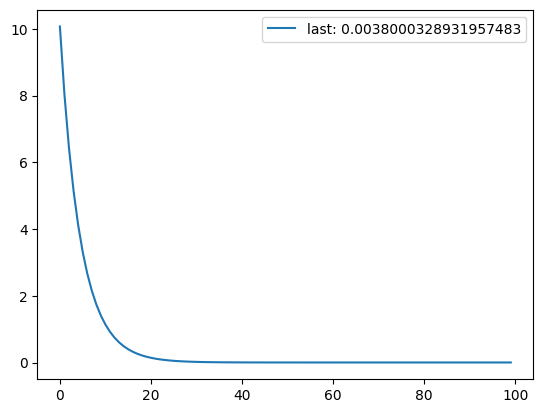

In [19]:
plt.plot(losses, label=f"last: {losses[-1]}")
plt.legend()
plt.show()

In [20]:
items_ = torch.arange(bandit_data["n_actions"])
behavior_policy_logit = []
for user in users:
    pi_b_logit_ = model(user, items_).detach().numpy()
    behavior_policy_logit.append(pi_b_logit_)

behavior_policy_logit = np.array(behavior_policy_logit)
tau=1.0
action_dist = softmax(behavior_policy_logit) / tau

In [21]:
selected_actions = sample_action_fast(action_dist)

In [22]:
indicator = bandit_data["action"] == selected_actions

In [23]:
np.unique(indicator, return_counts=True)

(array([False,  True]), array([9849,  151]))

In [24]:
bandit_data["reward"].mean()

0.0038

In [25]:
bandit_data["reward"][indicator].mean()

0.006622516556291391

In [27]:
151 / 10000

0.0151

In [28]:
int(1374327 * 0.0151)

20752

In [15]:
# フルデータでやると2万レコードは取れそう。MFが生成したデータとして